In [1]:
from core import download_IC

In [2]:
from core import readfiles
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *

read icdata
read uptdata
read eadata
read mspdata


@njit(fastmath=True)
def earea_r(season, i, j):
    se =  np.int32(ea_season(season))
    return earea[se][i + 40*j]

In [3]:
all_enu = np.logspace(11.001, 19, 1000)
gamma_arr = [-1, -2.2, -2.5, -3]
phi0m = [1e-46, 1e-45, 1e-41, 1e-41]

In [4]:
all_Bi = signals(4).compute_background()

In [5]:
all_Si = np.asfarray([signals(gamma_arr[i]).compute_signal() for i in tqdm(prange(4))])

100%|██████████| 4/4 [01:34<00:00, 23.72s/it]


In [16]:
all_Si[2]

array([1.35652808e-012, 2.91694886e-004, 3.31550137e-002, ...,
       3.06243494e-005, 7.80886092e-068, 9.42751921e-153])

In [6]:
#For each energy, find ns for all pulsars summed over all seasons and sum ns over all pulsars for each energy
#FIND TS as in eqn 3 of 2205.15963

@njit(fastmath=True)
def ns_singleseason_sing_psr_HAT(dec,enu, gamma, phi0 = 1e-40, season=0):
    '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


    tt_upt = t_upt[season]
    if enu <= 1e11 or enu > 1e19:
        return 0.0
    else:
        k=0
        l=0
        for i in range(0, len(e_nu)):
            if e_nu[i] <= enu and e_nu[i+1] > enu:
                for j in range(0, len(dec_nu)):
                    if dec_nu[j] <= dec and dec_nu[j+1] > dec:
                        k=i
                        l=j
                        break
                break

        temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
        return tt_upt * (enu**2) * temp_ea * dfde(enu, gamma, phi0)


In [7]:
#For each energy, find ns for all pulsars summed over all seasons and sum ns over all pulsars for each energy
#FIND TS as in eqn 3 of 2205.15963

all_TSS = []
nss_all_gamma = []
for gamma in prange(4):
    nss_all_eng = []
    for enu in prange(len(all_enu)):
        psrns = 0
        for psrdec in prange(p):
            for season in range(10):    
                psrns += ns_singleseason_sing_psr_HAT(psrdec, all_enu[enu], gamma_arr[gamma], phi0m[gamma],season=season)
                # nss.append(ns_singleseason_sing_psr_HAT(psrdec, all_enu[enu], gamma_arr[gamma], season=season))
        nss_all_eng.append(psrns)
    
    @njit
    def TS_for_all_psrs2(nsa):
        return Ts_arr2(nsa, all_Si[gamma], all_Bi, Ns)

    pool = mul.Pool(12, maxtasksperchild=200)
    op_arr = pool.map_async(TS_for_all_psrs2, nss_all_eng)
    temp = op_arr.get()
    pool = []
    op_arr = []
    all_TSS.append(temp)

    # nss_all_gamma.append(nss_all_eng)

In [8]:
for i in range(4):
    print(min(all_TSS[i]), max(all_TSS[i]))

-219.26242518260503 3.997246977860233e-11
-1134450.0 0.0
-109.41815957632622 0.0
-184.87922285428985 0.0


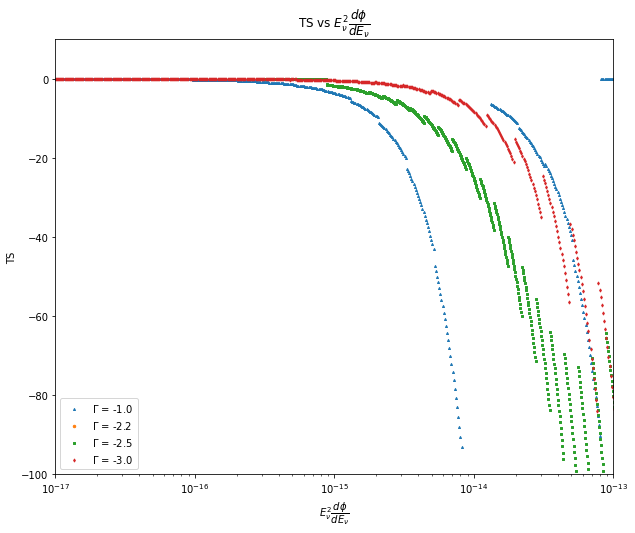

In [9]:
all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)
phi0 = 1e-40
e2dfde = [] 
for i in prange(4):
    temp = []
    for eng in range(1000):
        temp.append((all_enu[eng]**2) * dfde(all_enu[eng], gamma_arr[i], phi0m[i]))
    e2dfde.append(temp)

e2dfde = np.asarray(e2dfde)
mark = ['^', 'o', 's', 'd']
plt.figure(figsize=(10,8))
for i in [0, 1, 2, 3]:#range(4):
    plt.scatter(e2dfde[i], all_TSS[i], label='$\Gamma$ = ' + str(gamma_arr[i]), s=4 + i*(i-2)*(i-3), marker= mark[i])

plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$E^2_{\u03BD} \dfrac{d\phi}{dE_{\u03BD}}$')
plt.ylabel('TS')
plt.title('TS vs $E^2_{\u03BD} \dfrac{d\phi}{dE_{\u03BD}}$')
plt.xlim(1e-17, 1e-13)
plt.ylim(-100, 10)
plt.show()